In [1]:
# initial setup ###
import numpy as np
from vizdoom import *
import random

def create_environment():
    game = DoomGame()
    game.load_config('vizdoom/myConfig.cfg')  
    game.set_doom_scenario_path('vizdoom/square.wad')
    #game.set_doom_scenario_path('vizdoom/tmaze.wad')
    #game.set_doom_map('map01')
    game.set_mode(Mode.PLAYER)
    game.set_window_visible(False)
    game.set_automap_buffer_enabled(True)
    game.set_automap_mode(WHOLE)
    game.set_available_buttons([MOVE_LEFT, MOVE_RIGHT, MOVE_FORWARD, MOVE_BACKWARD, TURN_RIGHT]) 
    #game.set_available_buttons([MOVE_FORWARD, MOVE_BACKWARD, TURN_RIGHT, TURN_LEFT]) 
    game.set_available_game_variables([POSITION_X, POSITION_Y, ANGLE, VELOCITY_X, VELOCITY_Y, CAMERA_FOV])
    game.init()     
    return game

def move(game, avoidWall=False, speed=5):
    actions = np.identity(game.get_available_buttons_size(), dtype = int)
    mask = np.ones(game.get_available_buttons_size(), dtype=bool)
    if mask.size > 4:
        mask[4] = False # TURN_RIGHT
    if avoidWall:
        pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
        if pos[0] > 150:
            mask[2] = False # inhibit MOVE_FORWARD
        if pos[0] < -150:
            mask[3] = False # inhibit MOVE_BACKWARD
        if pos[1] > 150:
            mask[0] = False # inhibit MOVE_LEFT
        if pos[1] < -150:
            mask[1] = False # inhibit MOVE_RIGHT
    actions = actions[mask].tolist()
    action = random.choice(actions)
    reward = game.make_action(action, speed)
    return action

def go_back_turn(game, ori_dir, speed=5):
    actions = np.identity(game.get_available_buttons_size(), dtype = int)[:4, :]
    opposite = ori_dir
    
    if ori_dir[0]:
        opposite[0] = 0
        opposite[1] = 1
        actions = np.delete(actions, 0, axis=0)
    elif ori_dir[1]:
        opposite[0] = 1
        opposite[1] = 0
        actions = np.delete(actions, 1, axis=0)
    elif ori_dir[2]:
        opposite[2] = 0
        opposite[3] = 1
        actions = np.delete(actions, 2, axis=0)
    elif ori_dir[3]:
        opposite[2] = 1
        opposite[3] = 0
        actions = np.delete(actions, 3, axis=0)
    
    reward = game.make_action(opposite, speed)
    return random.choice(actions.tolist())
    

In [2]:
### plotting utilities ###
import matplotlib.pyplot as plt
from scipy import stats
import cv2

def plot_traj(traj):
    #print((np.min(traj[:, 0]), np.max(traj[:, 0])));
    #print((np.max(traj[:, 1]), np.min(traj[:, 1])));
    plt.figure();
    plt.subplot(1, 1, 1);
    plt.plot(traj[:, 0], traj[:, 1], 'k-');
    plt.xlim((np.min(traj[:, 0]), np.max(traj[:, 0])));
    plt.ylim((np.min(traj[:, 1]), np.max(traj[:, 1])));
    plt.axis('scaled');
    #plt.axis('off');
    plt.title('Trajectory');
    plt.show();
    
def compute_receptive_field(act, x, y, bin_size):
    # batch size and the number of neurons
    num_neuron = act.shape[0];
    # sampling size for gaussian smoothing
    sample_size = int(np.minimum(bin_size[0], bin_size[1]) / 4);
    if sample_size % 2 == 0 :
        sample_size += 1;
    
    # receptive field
    receptive_fields = np.zeros((num_neuron, bin_size[1], bin_size[0]));
    # compute receptive field with spatial position
    map_x = x.reshape(-1);
    map_y = y.reshape(-1);
    for neuron_idx in np.arange(num_neuron):
        f = act[neuron_idx, :].reshape(-1);
        ratemap, _, _, _ = stats.binned_statistic_2d(map_y, map_x, f, 
                                                     statistic = lambda x : np.mean(x),
                                                     bins = [bin_size[1], bin_size[0]]);
        # Nan value complete
        ratemap_nan = np.copy(ratemap);
        nan_idx = np.where(np.isnan(ratemap_nan));
        
        # gaussian sampling 
        ratemap_nan[nan_idx] = 0.0;
        ratemap_nan = cv2.GaussianBlur(ratemap_nan, (sample_size, sample_size), 0);
        ratemap[nan_idx] = ratemap_nan[nan_idx];
        receptive_fields[neuron_idx] = ratemap;
    return receptive_fields;

def plot_receptive_field(activity, traj, plot_size=[1,1], bin_length=30, fig_size=[15,15]):
    ratemaps = compute_receptive_field(activity, traj[:, 0], traj[:, 1], [int(traj[:, 0].size/bin_length), int(traj[:, 1].size/bin_length)]);
    num_neuron = ratemaps.shape[0];
    plt.figure(figsize=fig_size);
    plt.axis('off');
    for neuron_idx in range(plot_size[0]*plot_size[1]):
        plt.subplot(plot_size[0], plot_size[1], neuron_idx + 1);
        plt.imshow(np.flipud(ratemaps[neuron_idx]), interpolation = 'gaussian');
    plt.show();
    
### 3D plot of grid/place cells ###
from mpl_toolkits.mplot3d import Axes3D
def plot3D(traj, data):
    fig = plt.figure()
    ax = []
    #for i in range(nGrids):
    #    ax.append(fig.add_subplot(4,3,i+1, projection='3d'))
    #    ax[i].scatter(trajectory[:, 0], trajectory[:, 1], gc[i].data, c=gc[i].data)
    #    plt.title("theta="+str(int(gc[i].theta/np.pi*180))+" k="+str(gc[i].k))
    
    #ax.append(fig.add_subplot(4,3,11, projection='3d'))
    ax.append(fig.add_subplot(111, projection='3d'))
    ax[0].scatter(traj[:, 0], traj[:, 1], data, c=data)
    
    plt.show()

In [7]:
### self-motion (position) based grid-place system ###
# grid cells should receive self-motion input, but here we just build a simple model from position information
lambdaRange = (100, 300) #(28,73)
gwMax = 1

def lambda2k(lamda):
    return 4*np.pi/np.sqrt(3)/lamda

class MGridCell:
    def __init__(self, r0):
        self.data = []
        self.theta = random.randint(0,60)/180.0*np.pi
        self.k = np.exp(random.uniform(np.log(lambda2k(lambdaRange[1])),np.log(lambda2k(lambdaRange[0]))))
        self.r0 = r0
        
    def response(self, pos, record=False):
        r = np.array([pos[0]-self.r0[0], pos[1]-self.r0[1]])
        k1 = np.array([np.cos(self.theta+np.pi/12)+np.sin(self.theta+np.pi/12),np.cos(self.theta+np.pi/12)-np.sin(self.theta+np.pi/12)])*self.k/np.sqrt(2)
        k2 = np.array([np.cos(self.theta+np.pi*5/12)+np.sin(self.theta+np.pi*5/12),np.cos(self.theta+np.pi*5/12)-np.sin(self.theta+np.pi*5/12)])*self.k/np.sqrt(2)
        k3 = np.array([np.cos(self.theta+np.pi*9/12)+np.sin(self.theta+np.pi*9/12),np.cos(self.theta+np.pi*9/12)-np.sin(self.theta+np.pi*9/12)])*self.k/np.sqrt(2)
        res = ((np.cos(np.dot(k1,r))+np.cos(np.dot(k2,r))+np.cos(np.dot(k3,r)))/3 + 0.5)* 2/3 * gwMax
        if record:
            self.data.append(res)
        return res

def weight(lamda, N):
    fmax = 40 #20
    sigma = 100 #50 #12
    return (fmax/gwMax)*2*np.pi*(sigma**2)*(np.exp(-4/3*(np.pi**2)*(sigma**2)/(lamda**2))/(lamda**2))*(2*np.pi/N)*np.log(lambdaRange[1]/lambdaRange[0])

class MPlaceCell:
    def __init__(self, nGrids, r0):
        self.data = []
        self.grids = [] # list of tuples of (MGridCell object, corresponding weight)
        self.r0 = r0
        for i in range(nGrids):
            grid = MGridCell(r0)
            self.grids.append( ( grid, weight(lambda2k(grid.k), nGrids) ) )

    def response(self, pos, record=True):
        Cinh = 8 #0.1
        summation = sum([grid[1]*grid[0].response(pos) for grid in self.grids])-Cinh
        if summation>=0:
            if record:
                self.data.append(summation)
            return summation
        else:
            if record:
                self.data.append(0)
            return 0
    
class MPCpopulation:
    def __init__(self, map_size, env_range, nGrids):
        self.MPCs = []
        self.rw = np.zeros([map_size[0]*map_size[1], map_size[0]*map_size[1]]) # recurrent weights
        self.cnt = 0
        
        for i in range(map_size[0]):
            for j in range(map_size[1]):
                r0 = [random.randint(env_range[0][0], env_range[0][1]), random.randint(env_range[1][0], env_range[1][1])]
                self.MPCs.append(MPlaceCell(nGrids, r0))
                
    def trainHopfield(self, y):
        #nNodes = len(self.MPCs)
        #tmp = np.zeros((y.shape[0], nNodes, nNodes))
        #for i in range(y.shape[0]):
        #    tmp[i] = np.matmul(y[i].reshape((1, -1)).T, y[i].reshape((1, -1)))
        #rw = np.sum(tmp, axis=0)/y.shape[0]
        #mask = np.ones((nNodes, nNodes)) - np.identity(nNodes)
        #rw = rw*mask
        #self.rw = ( self.rw*self.cnt + rw/np.linalg.norm(rw.reshape(-1), axis=0) )/(self.cnt+1)
        #self.cnt += 1
        nNodes = len(self.MPCs)
        rw = np.matmul(y.reshape((1, -1)).T, y.reshape((1, -1)))
        mask = np.ones((nNodes, nNodes)) - np.identity(nNodes)
        rw = rw*mask
        self.rw = ( self.rw*self.cnt + rw/np.linalg.norm(rw.reshape(-1), axis=0) )/(self.cnt+1)
        self.cnt += 1
        
    def showRW(self):
        plt.figure();
        plt.imshow(self.rw);
        plt.show();
    
    def triggeredResponse(self, act):
        #print(np.max(act), np.max(self.rw), np.max(np.matmul(act.reshape((1, -1)), self.rw)))
        return np.matmul(act.reshape((1, -1)), self.rw)
    

In [4]:
### goal cell ###
class GoalCell:
    def __init__(self, nPC):
        self.nPC = nPC # number of place cells
        self.w = np.zeros(nPC)
        self.data = []
    
    def response(self, PCact):
        res = np.dot(self.w, PCact)
        self.data.append(res)
        return res
    
    def memorizeReward(self, PCact, PCpop, tRange = 10):
        decay = 0.8
        # synapses from currently firing place cells are enhanced
        self.w += PCact/np.linalg.norm(PCact, axis=0)
        ripple = PCact/np.linalg.norm(PCact, axis=0)
        for t in range(tRange):
            ripple += PCpop.triggeredResponse(ripple).reshape(-1)
            ripple /= np.linalg.norm(ripple, axis=0)
            self.w +=  ripple * (decay**(t+1))
        self.w /= np.linalg.norm(self.w, axis=0)

0 100 200 300 400 

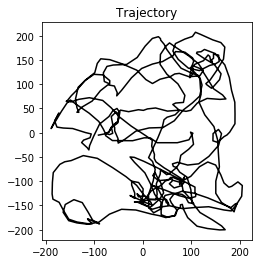

In [8]:
### main program - simulation & collecting data ###
import time
import scipy.io as sio
import sys
np.seterr(divide='ignore', invalid='ignore')

game = create_environment()
game.new_episode()
#cv2.imwrite('map.jpg', game.get_state().automap_buffer);

game.make_action([0, 0, 0, 0, 1], 15)
initial_state = game.get_state().screen_buffer
trajectory = np.zeros([0, 2])

## V1 ##
#v1 = V1(initial_state)

## MPC ##
env_range = [[-190, 190], [-190, 190]]
map_size = [15, 15]
nGrids = 20
MPCpop = MPCpopulation(map_size, env_range, nGrids)
        
## Goal Cell ##
gc = GoalCell(len(MPCpop.MPCs))
rewardPos = [100, 100]
tolerance = 10

''' exploration and initial search '''
speed = 5
random.seed(34)
for i in range(500):
    if i%100 == 0:
        sys.stdout.write(str(i)+' ')
        
    move(game, True, speed);
    pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
    if game.get_state() is None or game.is_episode_finished():
        break
    trajectory = np.append(trajectory, [pos], axis=0)
    #angle = float(game.get_game_variable(ANGLE)/game.get_game_variable(CAMERA_FOV))
    #v1_activity = v1.response(game.get_state().screen_buffer)
    mpc_activity = [mpc.response(pos) for mpc in MPCpop.MPCs]
    
    # exploration
    MPCpop.trainHopfield(np.array(mpc_activity))
    
    # searching
    if i >= 800: 
        if pos[0]>rewardPos[0]-tolerance and pos[0]<rewardPos[0]+tolerance and pos[1]>rewardPos[1]-tolerance and pos[1]<rewardPos[1]+tolerance: 
            print("reward! ", i)
            search_end = i
            gc.memorizeReward(np.array(mpc_activity), MPCpop)
            gc_max = gc.response(mpc_activity)
            break
    gc.response(mpc_activity)

# this is only for getting and plotting goal cell responses throughout the environment
#for i in range(env_range[0][0], env_range[0][1], 10):
#    for j in range(env_range[1][0], env_range[1][1], 10):
#        pos = [i, j]
#        trajectory = np.append(trajectory, [pos], axis=0)
#        mpc_activity = [mpc.response(pos) for mpc in MPCpop.MPCs]
#        MPCpop.trainHopfield(np.array(mpc_activity).reshape(1, -1))
#        gc.response(mpc_activity)

''' randomly move to another initial position '''
for i in range(10):
    move(game, True, speed=20);

''' exploitation '''
speed = 3
p = 0.01
threshold_low = gc_max*0.1
threshold_high = gc_max*0.3
direction = move(game, True) # randomly decide a direction
for i in range(500):
    if i%50 == 0:
        sys.stdout.write(str(i)+' ')
    if game.get_state() is None or game.is_episode_finished():
        break
    
    pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
    trajectory = np.append(trajectory, [pos], axis=0)
    mpc_activity = [mpc.response(pos) for mpc in MPCpop.MPCs]
    MPCpop.trainHopfield(np.array(mpc_activity))
    gc_activity = gc.response(mpc_activity)
    
    if gc_activity < threshold_low:
        sys.stdout.write("fast ")
        direction = move(game, True, 8) # fast random walk when too far away
    elif gc_activity < threshold_high or random.random() < p:
        sys.stdout.write("slow ")
        direction = move(game, True, speed) # slow down random walk when between 2 thresholds
    elif gc.data[-2] < gc_activity or gc.data[-3] < gc_activity: # current position is better than the last; i.e. direction is good
        sys.stdout.write("following gradient ")
        game.make_action(direction, speed);
    else:
        sys.stdout.write("going back and turn ")
        direction = go_back_turn(game, direction, speed)
        game.make_action(direction, speed);
    print(pos, gc_activity)
    
    pos = [game.get_game_variable(POSITION_X), game.get_game_variable(POSITION_Y)]
    if pos[0]>rewardPos[0]-tolerance and pos[0]<rewardPos[0]+tolerance and pos[1]>rewardPos[1]-tolerance and pos[1]<rewardPos[1]+tolerance: 
        print("reward!")
        gc.memorizeReward(np.array(mpc_activity), MPCpop)
        trajectory = np.append(trajectory, [pos], axis=0)
        break

#time.sleep(1)
game.close()
plot_traj(trajectory)

# save data into .mat file
#n=4
#simData = {'pos': trajectory, 'v1': v1.data, 'vn_height': v1.vn_height, 'vn_width': v1.vn_width}
#sio.savemat('data/v1data'+str(n)+'.mat', simData, appendmat=False)

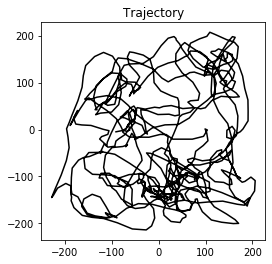

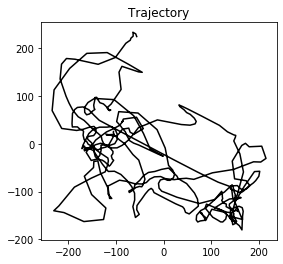

In [124]:
plot_traj(trajectory[:search_end, :])
plot_traj(trajectory[search_end+1:, :])

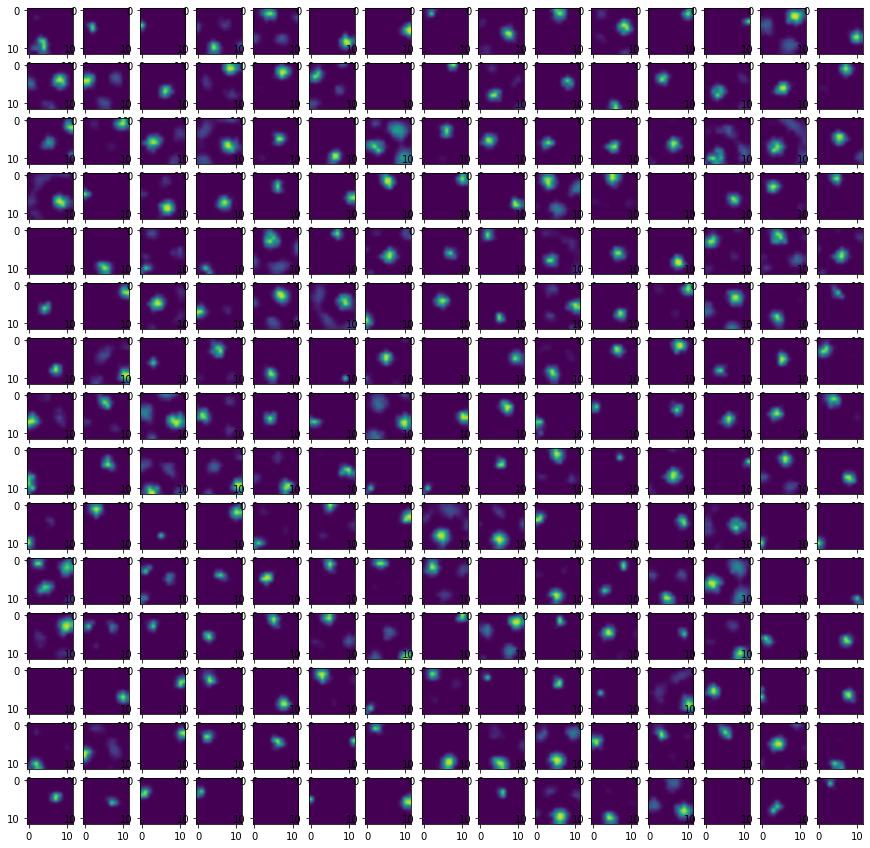

In [6]:
#print(np.max(MPCpop.MPCs[0].data))
plot_receptive_field(np.array([mpc.data for mpc in MPCpop.MPCs]), trajectory, plot_size=map_size, bin_length=40)
#MPCpop.showRW()
#plot_receptive_field(np.array([gc.data[search_end+1:]]), trajectory[search_end+1: , :], plot_size=[1,1], bin_length=40, fig_size=[5, 5])

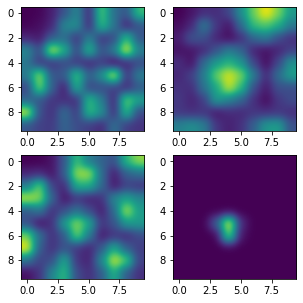

In [15]:
plot_receptive_field(np.array([MPCpop.MPCs[3].grids[13][0].data[:], MPCpop.MPCs[3].grids[3][0].data[:], MPCpop.MPCs[3].grids[7][0].data[:], MPCpop.MPCs[3].data[:]]), trajectory[: , :], plot_size=[2,2], bin_length=50, fig_size=[5, 5])
#plot_receptive_field(np.array([MPCpop.MPCs[3].data[:]]), trajectory[: , :], plot_size=[1,1], bin_length=40, fig_size=[5, 5])

In [5]:
### primary visual cortex ###
import cv2
from scipy.ndimage.interpolation import shift

def downsample(img, size):
    res = np.zeros([int(img.shape[0]/size), int(img.shape[1]/size)])
    for y in range(int(img.shape[0]/size)):
        for x in range(int(img.shape[1]/size)):
            res[y, x] = np.average(img[y*size: (y+1)*size, x*size: (x+1)*size])
    return res

class V1:
    def __init__(self, initState, kernel_size=20):   
        self.kernel_size = kernel_size
        self.height = initState.shape[0] # input image size
        self.width = initState.shape[1]
        self.vn_height = int(self.height/self.kernel_size*2)
        self.vn_width = int(self.width/self.kernel_size*2)
        self.nNeurons = self.vn_height * self.vn_width
        self.data = np.zeros([0, self.nNeurons])
        
    def response(self, state, angle=0.0): 
        #print(state) # shape: (480, 640)
        #cv2.imwrite('state_original.jpg', state);
        
        # ego- to allo- (???)
        #state = np.roll(state, int(angle*state.shape[1]), axis=1)
        #state = shift(state, (0, int(angle*state.shape[1]/360.0)),  cval=0)
        #cv2.imwrite('state_allo.jpg', state);
        
        # Gabor filter
        filter_outputs = np.zeros([0, self.vn_height, self.vn_width])
        for i in range(4):
            g_kernel = cv2.getGaborKernel((self.kernel_size, self.kernel_size), sigma=8.0, theta=np.pi/4.0*i, lambd=15.0, gamma=1.5, psi=0)
            #cv2.imwrite('kernel.jpg', g_kernel*255/np.max(g_kernel));
            filter_output = downsample(cv2.filter2D(state, cv2.CV_8UC3, g_kernel), int(self.kernel_size/2))
            filter_outputs = np.append(filter_outputs, filter_output.reshape([1, self.vn_height, self.vn_width]), axis=0)
            #cv2.imwrite('filter_output'+str(i)+'.jpg', filter_output);
        filtered_state = np.amax(filter_outputs, axis=0).reshape([self.vn_height, self.vn_width])
        #cv2.imwrite('state_filtered.jpg', filtered_state);
        
        # 2D to 1D
        filtered_state = filtered_state.reshape((1, -1)) # shape => (1, vn_height * vn_width)
        # sum normalization (-> length unity)
        filtered_state = filtered_state / np.max(filtered_state)
        filtered_state = filtered_state / np.tile(np.linalg.norm(filtered_state, axis=1).reshape((-1, 1)), (1, filtered_state.shape[1]))
        
        self.data = np.append(self.data, filtered_state, axis=0)
        return filtered_state


In [45]:
### visual place cell ###
import sys

class VPlaceCell: 
    def __init__(this, nDim, eta=0.2, mapSize=[10, 10]): 
        this.eta = eta;
        this.mapSize = mapSize; # 2D size of number of place fields
        this.nDim = nDim; # number of pixels of visual input
        this.nNodes = mapSize[0] * mapSize[1];
        this.n_x = mapSize[0];
        this.n_y = mapSize[1];
        
        # create weight space
        this.w = np.random.rand(this.nDim, this.nNodes);
        # normalize the weight
        this.w = this.w / np.tile(np.sqrt(np.sum(this.w * this.w, axis = 0)), (this.nDim, 1));
        
        # recurrent weights (Hopfield; fire-together-wire-together)
        this.rw = np.zeros((this.nNodes, this.nNodes))

    def train(this, dataSet, nIter=1):
        cnt = 0;
        nSamples = dataSet.shape[0];
        sys.stdout.write('Training In VPC Competitve Learning:');
        for iterIdx in range(nIter):
            for sampleIdx in range(nSamples):
                # get one sample
                sample = dataSet[sampleIdx : sampleIdx + 1];
                # find the win neuron
                winIdx, neuronOutput = this.computeWinNeuron(sample);
                # update weight
                this.updateWeight(sample, winIdx, neuronOutput);
                # count
                cnt = cnt + 1;
                # process
                if cnt % 500 == 0:
                    sys.stdout.write(str(cnt) + ' ');
        sys.stdout.write('\n');
    
                
    def computeWinNeuron(this, neuronInput):
        # forward output
        neuronOutput = np.dot(neuronInput, this.w)
        # add some noise
        winIdx = np.argmax(neuronOutput + 2 * np.random.rand(1, this.nNodes));
        return winIdx, neuronOutput;

    
    def updateWeight(this, neuronInput, winIdx, neuronOutput):
        dw = this.eta * neuronInput * neuronOutput[0, winIdx];
        # on-line update the winning neuron weight
        this.w[:, winIdx : winIdx + 1] += dw.T;
        # normalization
        if np.sum(this.w[:, winIdx]) != 0:
            this.w[:, winIdx] = this.w[:, winIdx] / np.sqrt(np.sum(this.w[:, winIdx] * this.w[:, winIdx]));
        
    def estimate(this, x, e=0.925):
        # forward output
        y = np.dot(x, this.w);
        # E% max inhibition
        y = y - e * np.tile(np.reshape(np.max(y, 1), [-1, 1]), [1, y.shape[1]]);
        y = y * (y > 0);
        y = y / (1.0 - e);
        return y;
    
    def trainHopfield(this, y):
        tmp = np.zeros((y.shape[0], this.nNodes, this.nNodes))
        for i in range(y.shape[0]):
            tmp[i] = np.matmul(y[i].reshape((1, -1)).T, y[i].reshape((1, -1)))
        this.rw = np.sum(tmp, axis=0)
        mask = np.ones((this.nNodes, this.nNodes)) - np.identity(this.nNodes)
        this.rw = this.rw*mask
        plt.figure();
        plt.imshow(this.rw.reshape(this.nNodes, this.nNodes));
        plt.show();
        print(np.argmax(this.rw), np.argmax(this.rw)/this.rw.shape[0], np.argmax(this.rw)%this.rw.shape[0])

Training In VPC Competitve Learning:500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 


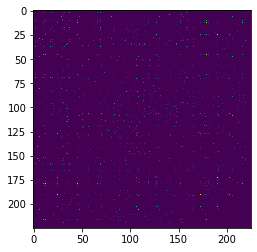

5815 25.844444444444445 190


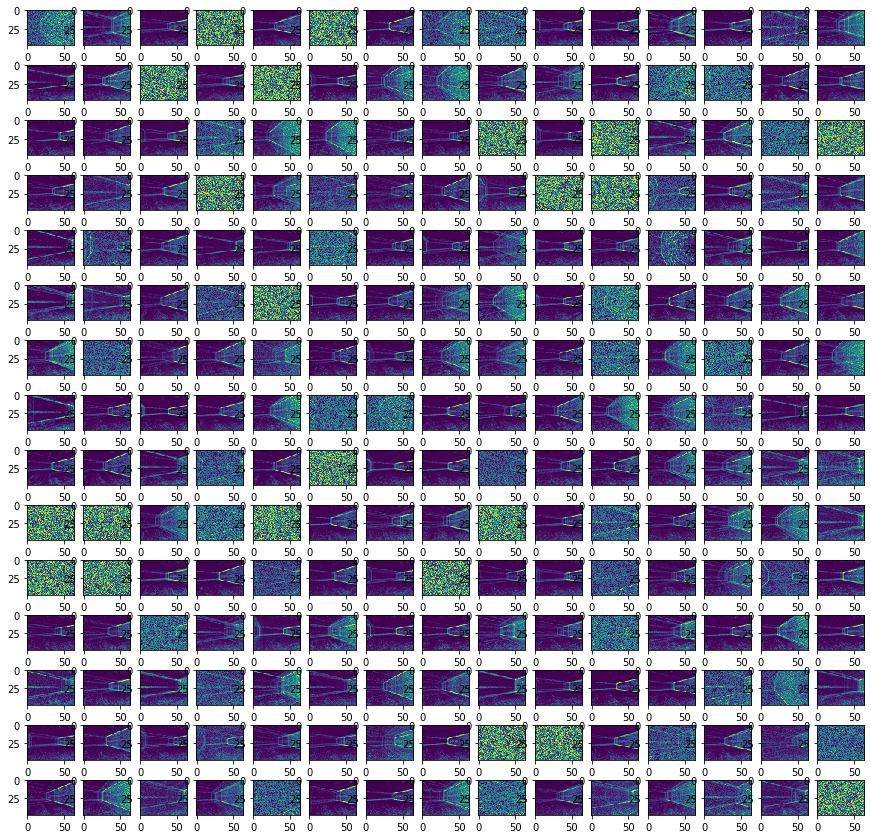

In [46]:
### VPC simulation & plot ###
# (should be able to run independently with data in file and the VPC definition cell)
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as sio

mapSize = [15, 15]
for i in range(3):
    data = sio.loadmat('data/v1data'+str(i+1)+'.mat', appendmat=False)
    if i==0:
        v1data = data['v1']
        trajectory = data['pos']
        vn_height = np.asscalar(data['vn_height'])
        vn_width = np.asscalar(data['vn_width'])
    else:
        v1data = np.append(v1data, data['v1'], axis=0)
        trajectory = np.append(trajectory, data['pos'], axis=0)

vpc = VPlaceCell(v1data.shape[1], eta=0.6, mapSize=mapSize)
vpc.train(v1data, nIter=3)

# estimation
pred_y = vpc.estimate(v1data[-1000: , :])
vpc.trainHopfield(pred_y)

### plotting for VPC ###
def compute_receptive_field1(act, x, y, bin_size):
    # batch size and the number of neurons
    num_neuron = act.shape[1];
    # sampling size for gaussian smoothing
    sample_size = int(np.minimum(bin_size[0], bin_size[1]) / 4);
    if sample_size % 2 == 0 :
        sample_size += 1;
    
    # receptive field
    receptive_fields = np.zeros((num_neuron, bin_size[1], bin_size[0]));
    # compute receptive field with spatial position
    map_x = x.reshape(-1);
    map_y = y.reshape(-1);
    for neuron_idx in np.arange(num_neuron):
        f = act[:, neuron_idx].reshape(-1);
        ratemap, _, _, _ = stats.binned_statistic_2d(map_y, map_x, f, 
                                                     statistic = lambda x : np.mean(x),
                                                     bins = [bin_size[1], bin_size[0]]);
        # Nan value complete
        ratemap_nan = np.copy(ratemap);
        nan_idx = np.where(np.isnan(ratemap_nan));
        
        # gaussian sampling 
        ratemap_nan[nan_idx] = 0.0;
        ratemap_nan = cv2.GaussianBlur(ratemap_nan, (sample_size, sample_size), 0);
        ratemap[nan_idx] = ratemap_nan[nan_idx];
        receptive_fields[neuron_idx] = ratemap;
    return receptive_fields;

def plot_receptive_field1(RF_pop, s_idx, e_idx, plot_size = [5, 5]):
    num_neuron = RF_pop.shape[0];
    plt.figure(figsize = [15, 15]);
    for neuron_idx in np.arange(s_idx, e_idx):
        plt.subplot(plot_size[0], plot_size[1], neuron_idx + 1 - s_idx);
        plt.imshow(RF_pop[neuron_idx], interpolation = 'gaussian');
    plt.show();
    
# show the weight matrix
plt.figure(figsize = [15, 15]);
for pcIdx in np.arange(mapSize[0]*mapSize[1]):
    plt.subplot(mapSize[0], mapSize[1], pcIdx + 1);
    plt.imshow(vpc.w[:, pcIdx].reshape(vn_height, vn_width));
plt.show();


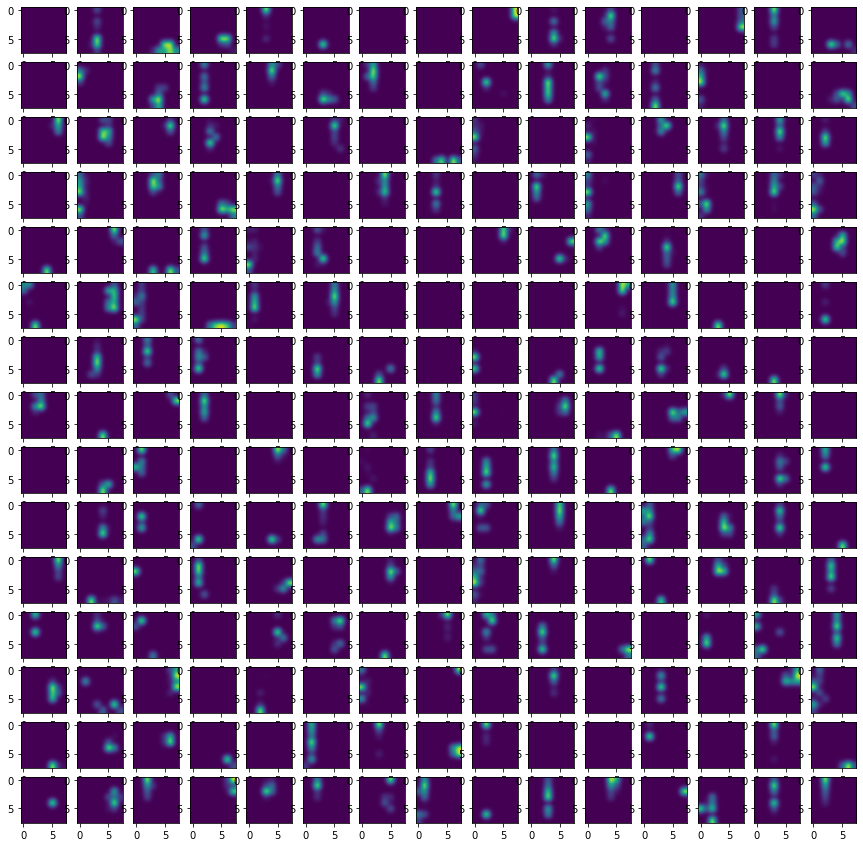

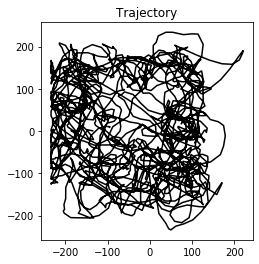

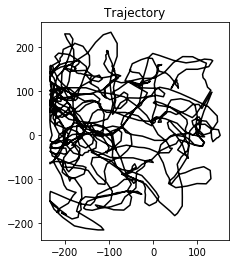

In [15]:
# show place fields
ratemaps = compute_receptive_field1(pred_y, trajectory[-1000:, 1], trajectory[-1000:, 0], [8, 8]);
plot_receptive_field1(ratemaps, 0, vpc.nNodes, plot_size = mapSize)

plot_traj(trajectory[:-1000, :]) #training
plot_traj(trajectory[-1000:, :]) #testing